# MAST Astroquery Exoplanet Demo

This is a demo to show how some of the basic MAST API services work with exoplanet data in MAST using the astroquery.mast module. Specifically, we show how to find and download Hubble and Kepler data for exoplanets.

Astroquery documentation available here: https://astroquery.readthedocs.io/en/latest/mast/mast.html

When the astrquery.mast module is released (coming soom), the astroquery module can be installed following the directions here: https://astroquery.readthedocs.io/en/latest/index.html#installation

For the time being, you can download the astroquery directly from github by following the "Build from source" installation instructions. Don't forget to add the astrquery directory to you PYTHONPATH in order to import from there.

In [1]:
### Set-up imports
import sys
import os
 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from astroquery import mast
import astropy
from astropy.io import fits
from astropy.table import Table

## 1. Getting Hubble Data through the API

In [2]:
### STEP 1: Not necessary with astroquery: Given an object name, find its RA and Dec.
### STEP 2: Do a cone search at the position of the object.
### This returns a list of all observations in MAST at this position. DOES NOT DOWNLOAD DATA.
### Setting radius to 0.0 will guarantee that only observations that contain the target
### in their footprints are returned

mastDataTable = mast.Observations.query_object('WASP-19', radius=0.0)

In [3]:
### Show first 10 rows:
#print(mastDataTable[:10])

### Show the column headings:
print(mastDataTable.colnames)
#print(mastDataTable['dataURL'])
print(np.unique(mastDataTable['wavelength_region']))
### Print the table if you want to see it:
#print(mastDataTable)

u_inst = np.unique(mastDataTable['instrument_name'])
print('There are {} unique instruments: {}'.format(len(u_inst), u_inst.data))

['dataproduct_type', 'obs_collection', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'proposal_id', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'dataRights', 'mtFlag', 'srcDen', 's_region', 'jpegURL', 'dataURL', 'obsid', 'objID', 'distance']
wavelength_region
-----------------
         INFRARED
          OPTICAL
               UV
There are 2 unique instruments: ['STIS/CCD' 'WFC3/IR']


In [4]:
### Create 2 new tables, one for each instrument
wfc3_data = mastDataTable[mastDataTable['instrument_name'] == 'WFC3/IR']

print('WFC3 filters: {}'.format(np.unique(wfc3_data['filters']).data))

stis_data = mastDataTable[mastDataTable['instrument_name'] == 'STIS/CCD']

print('STIS filters: {}'.format(np.unique(stis_data['filters']).data))

WFC3 filters: ['F139M' 'G141']
STIS filters: ['G430L' 'G750L' 'MIRVIS']


Next, we move beyond exploring what data is in the archive and into downloading the data and looking at it.

### 1a. WFC3 data

In [5]:
### STEP 3: Choose which observations you want to get.
### STEP 4: Get a list of all available files for each observation

### I am choosing one direct (F139M) and one grism (G141) observation for the example.
### "obsid" is the parameter that the search function needs

### You can do this two different ways:
### 1. By providing the obsid values to the mast.Observations.get_product_list function
to_get = wfc3_data['obsid'][wfc3_data['filters'] == 'F139M'][0],wfc3_data['obsid'][wfc3_data['filters'] == 'G141'][0] 
print(to_get)
obsProducts = mast.Observations.get_product_list(to_get)

### 2. By giving mast.Observations.get_product_list with a row or rows from the table
### returned by mast.Observations.query_object
# to_get = astropy.table.vstack((wfc3_data[wfc3_data['filters'] == 'F139M'][0],wfc3_data[wfc3_data['filters'] == 'G141'][0]))
# obsProducts = mast.Observations.get_product_list(to_get)

print("Number of data products:",len(obsProducts))

#print(obsProducts.colnames)

('2002901006', '2002973641')
Number of data products: 18


In [6]:
### STEP 5: download data

downloaded_products = mast.Observations.download_products(obsProducts,
                                   mrp_only=False,
                                   extension='flt.fits')

Maybe you have some data reduction and analysis code that can pick up from here. 
I am just going to show what the science arrays looks like.

In [7]:
print(downloaded_products)

                   Local Path                   ...
----------------------------------------------- ...
./mastDownload/HST/IBH715ZLQ/ibh715zlq_flt.fits ...
./mastDownload/HST/ICAB01C5Q/icab01c5q_flt.fits ...


In [8]:
### obri04020 is the STIS file. WFC3 observation files start with 'i'
file1 = fits.open(downloaded_products['Local Path'][0]); ### the semicollon just supresses output
file2 = fits.open(downloaded_products['Local Path'][1]);

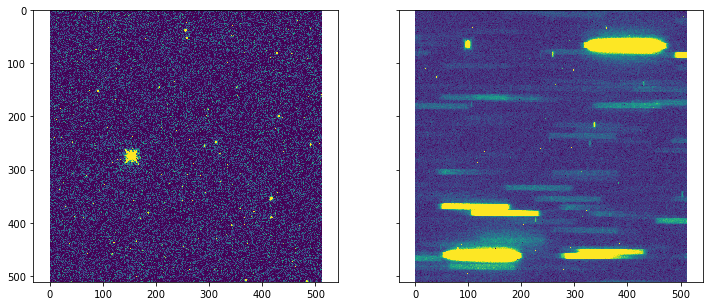

In [9]:
### Make a 2-panel plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(12)
ax1.imshow(file1['SCI'].data, cmap="viridis", clim=(0.0, 10.0))
ax2.imshow(file2['SCI'].data, cmap="viridis", clim=(5.0, 500.0))

### 1b. STIS data

In [10]:
### Follow the same sequence:
obsProducts = mast.Observations.get_product_list(stis_data[10])
print('Number of files: {}'.format(len(obsProducts)))
downloaded_products = mast.Observations.download_products(obsProducts,
                                   mrp_only=False,
                                   extension=['flt.fits','sx1.fits','sx2.fits'])

Number of files: 14


In [11]:
sx1 = Table.read(downloaded_products['Local Path'][1]) ### this is not a quite a standard table format
#sx1 = fits.open(downloaded_products['Local Path'][1])
sx2 = fits.open(downloaded_products['Local Path'][2])
#print(sx2_tab.info())
#print(len(sx1_tab['WAVELENGTH'][0]))

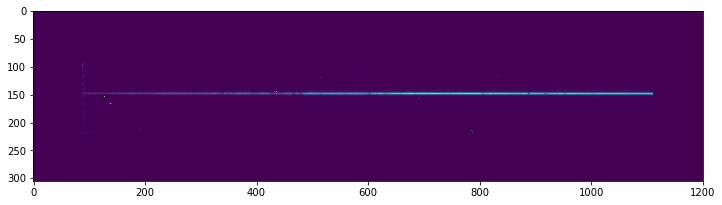

In [12]:
plt.figure(figsize=(12,10))
plt.imshow(sx2[1].data, cmap='viridis', clim=(0,1.4628e-13))

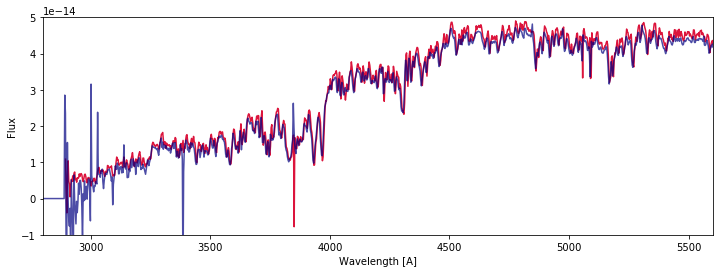

In [13]:
### Plot of the 1D spectrum

plt.figure(figsize=(12,4))

### Plot the 1D spectrum from the SX1 file
plt.plot(sx1['WAVELENGTH'][0], sx1['FLUX'][0], color='crimson')

### Create the wavelength array for the 2D spectrum using the header keywords
wave = sx2[1].header['CRVAL1'] + sx2[1].header['CD1_1']*(np.arange(np.shape(sx2[1].data)[1])-sx2[1].header['CRPIX1'])
### Plot the coadd across the dispersion direction from the 2D spectrum 
### Division by 10 is the flux-by-eye (not correct, just for the plot)
plt.plot(wave, np.sum(sx2[1].data, axis=0)/10, color='navy', alpha=0.7)

plt.xlim([2800.,5600.])
plt.ylim([-1e-14,5e-14])
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

## 2. Getting Kepler Data through the API

In [14]:
### STEP 1 & 2

mastDataTable = mast.Observations.query_object('Kepler-12b', radius=0.0)


### Show first 10 rows:
#print(mastDataTable[:10])

### Show the column headings:
#print(mastDataTable.colnames)
#print(mastDataTable['dataURL'])
#print(np.unique(mastDataTable['wavelength_region']))
### Print the table if you want to see it:
#print(mastDataTable)

u_inst = np.unique(mastDataTable['instrument_name'])
print('There are {} unique instruments: {}'.format(len(u_inst), u_inst.data))

There are 2 unique instruments: ['GPC1' 'Kepler']


In [15]:
print('Different types of observations: {}'.format(np.unique(mastDataTable['obs_collection']).data))

Different types of observations: ['Kepler' 'KeplerFFI' 'PS1']


In [16]:
### Split the output in 2 different tables: FFI and light curves
kepler_ffi_data = mastDataTable[mastDataTable['obs_collection'] == 'KeplerFFI']
kepler_data = mastDataTable[mastDataTable['obs_collection'] == 'Kepler']

In [17]:
print('Number of Kepler light curve datasets: {}'.format(len(kepler_data)))
print('Number of Kepler FFI datasets: {}'.format(len(kepler_ffi_data)))

Number of Kepler light curve datasets: 2
Number of Kepler FFI datasets: 39


Now lets grab a full frame image and some light curves.

In [18]:
### STEP 3:Choose which observations you want to get.
### STEP 4: Get a list of all available files the each observations
### STEP 5: Download data

to_get = astropy.table.vstack((kepler_ffi_data[0],kepler_data[0]))
obsProducts = mast.Observations.get_product_list(to_get)
print('Number of files: {}'.format(len(obsProducts)))
downloaded_products = mast.Observations.download_products(obsProducts,
                                   mrp_only=False,
                                   extension=['ffi-cal.fits','llc.fits'])

Number of files: 40


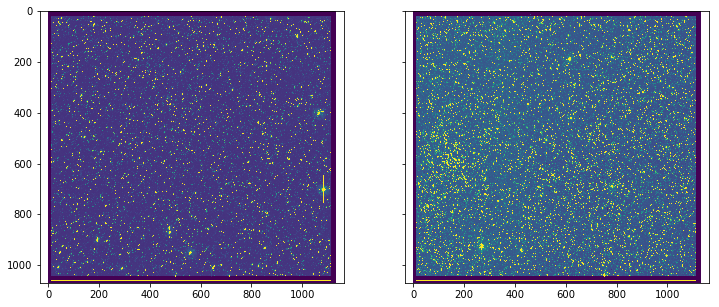

In [19]:
### What to these look like?
file = fits.open(downloaded_products['Local Path'][0])

### The following will give the structure of the file:
# print(file.info())

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(12)

### The first and the last detector
ax1.imshow(file[1].data, cmap='viridis', clim=(0,1000.))
ax2.imshow(file[84].data, cmap='viridis', clim=(0,1000.))

In [20]:
dir = os.path.split(downloaded_products['Local Path'][1])[0]
os.listdir(dir)

['kplr011804465-2009131105131_llc.fits',
 'kplr011804465-2009166043257_llc.fits',
 'kplr011804465-2009259160929_llc.fits',
 'kplr011804465-2009350155506_llc.fits',
 'kplr011804465-2010009091648_llc.fits',
 'kplr011804465-2010174085026_llc.fits',
 'kplr011804465-2010265121752_llc.fits',
 'kplr011804465-2010355172524_llc.fits',
 'kplr011804465-2011177032512_llc.fits',
 'kplr011804465-2011271113734_llc.fits',
 'kplr011804465-2012004120508_llc.fits',
 'kplr011804465-2012179063303_llc.fits',
 'kplr011804465-2012277125453_llc.fits',
 'kplr011804465-2013011073258_llc.fits',
 'kplr011804465-2013131215648_llc.fits']

Filename: ./mastDownload/Kepler/kplr011804465_lc_Q111111110111011101/kplr011804465-2011271113734_llc.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      58   ()      
  1  LIGHTCURVE  BinTableHDU    161   4573R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE    ImageHDU        48   (7, 6)   int32   
None


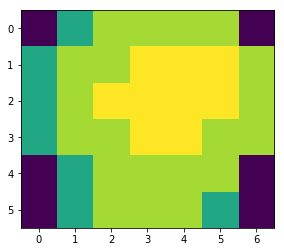

In [21]:
### The *llc* files are described here: http://archive.stsci.edu/kepler/manuals/archive_manual.pdf
### Here, again, you can plug your own analysis. I am just going to make some plots. 

### First show the aperture extension
file = fits.open(downloaded_products['Local Path'][10])
print(file.info())
plt.imshow(file[2].data, cmap='viridis',clim=(0.,15.))

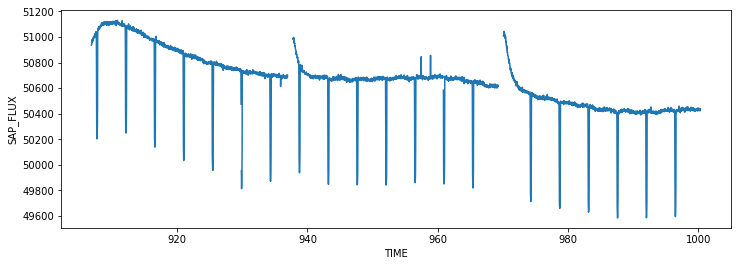

In [22]:
### Show the light curve
plt.figure(figsize=(12,4))

plt.plot(file[1].data['TIME'], file[1].data['SAP_FLUX'])
plt.xlabel('TIME')
plt.ylabel('SAP_FLUX')

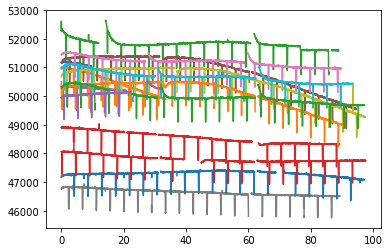

In [24]:
### Plot all the light curves

for file in downloaded_products['Local Path'][1:]:
    tab = Table.read(file);
    file = fits.open(file)
    plt.plot(tab['TIME'] - tab['TIME'][0], tab['SAP_FLUX'])
    #plt.xlim([-0.003, 0.003])
    #plt.plot(tab['TIME']-tab['TIMECORR']+(0.25 + 0.62*(5-file[1].header['TIMSLICE']))/86400, tab['SAP_FLUX'])